In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020522,2025-12-17T00:00:00,Detroit Red Wings,New York Islanders,0.5460,0.4406,0.7686,3,2,True,False,True
1,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          689      0.5298 0.2528   0.6991 0.5269   0.5254
Totals (Over/Under)  689      0.4717 0.2496   0.6922 0.5223   0.5269
Asian Handicap       689      0.7460 0.1893   0.5653 0.5680   0.7431


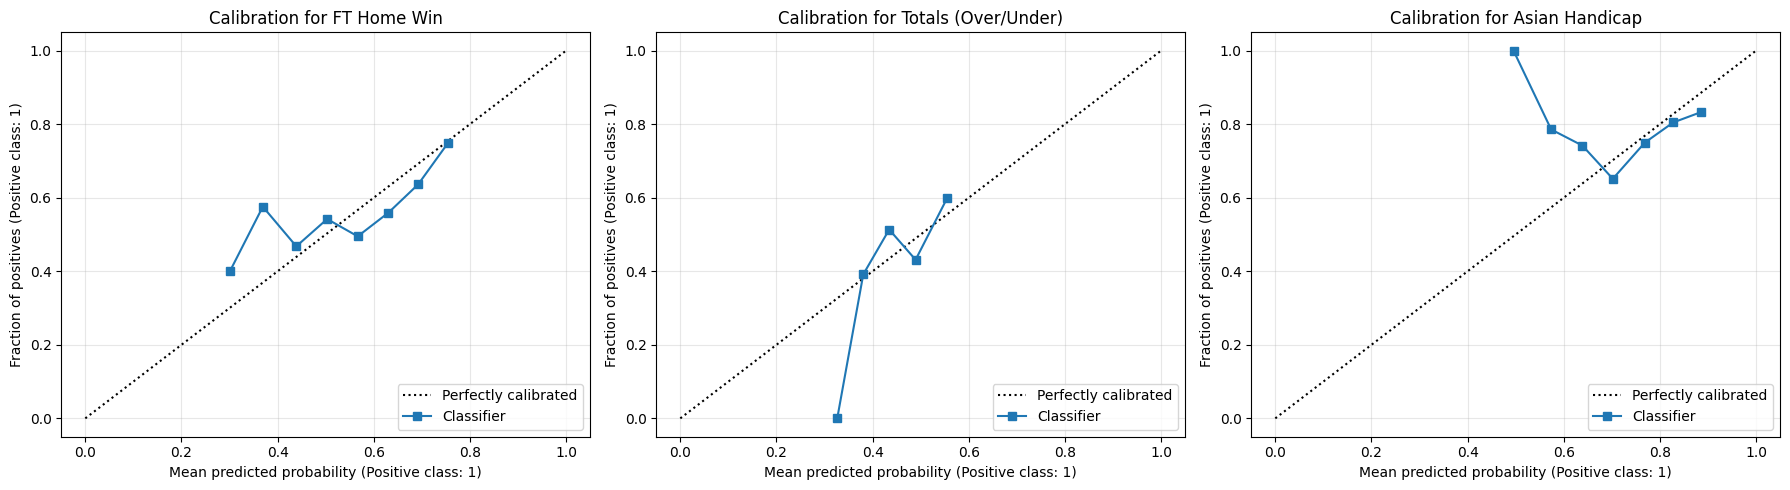

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=15)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          549      0.5301 0.2509   0.6949 0.5385   0.5264
Totals (Over/Under)  549      0.4718 0.2493   0.6918 0.5285   0.5191
Asian Handicap       549      0.7432 0.1905   0.5669 0.5728   0.7395


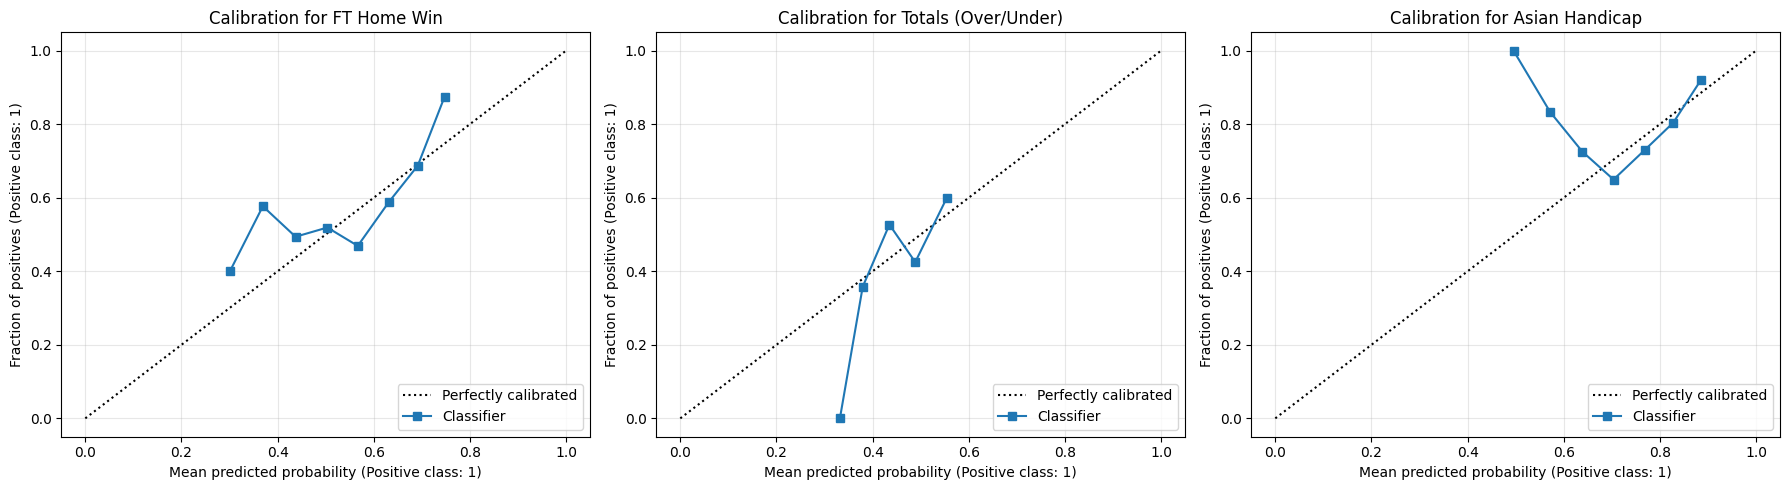

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=15)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500570,2026-01-14T04:00:00,Golden State Warriors,Portland Trailblazers,0.6272,0.5922,0.8119,119,97,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          395      0.5595 0.2342   0.6636 0.6479   0.6177
Totals (Over/Under)  395      0.5772 0.2510   0.7014 0.5951   0.5772
Asian Handicap       395      0.7595 0.1737   0.5238 0.6729   0.7494


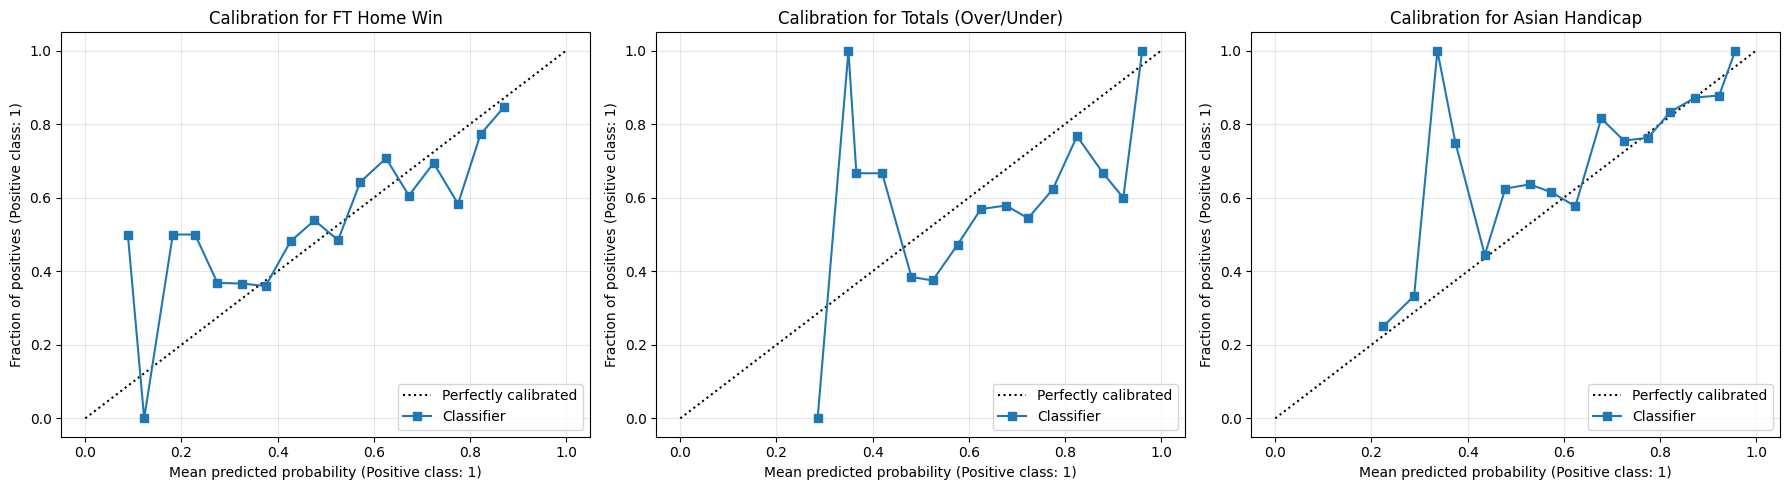

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=20)